# Demo: HRES T0

## Setup

To run this notebook, you will need a recent version of JupyterLab with iPyLeaflet and CartoPy installed. It is recommended to make a new Conda environment and install all three with `conda install -c conda-forge jupyterlab ipyleaflet cartopy`. In addition, you will need the following PyPI packages:

In [ ]:
!pip install -q fsspec gcsfs zarr<3

In [1]:
import logging
import warnings

# In this demo, we silence all warnings.
warnings.filterwarnings("ignore")

# But we do want to show what's happening under the hood!
logging.basicConfig(level=logging.WARNING, format="%(asctime)s [%(levelname)s] %(message)s")
logging.getLogger("aurora").setLevel(logging.INFO)

## Load an Initial Condition

To run Aurora, you need to initialise the model with the state of the world at a particular point in time. For this demo, we initialise Aurora with HRES T0, which is a state-of-the-art data set that is available in real time. Specifically, we initialise the model with the state of the world at 11 May 2022 UTC 12.

In [2]:
from datetime import datetime

from aurora.foundry.demo.hres_t0_data import load_batch

initial_condition = load_batch(day=datetime(2022, 5, 11))

## Produce Prediction on Azure AI Foundry

Now that we have an initial condition, we connect to the Foundry endpoint and run the model for 4 6-hour steps, producing predictions up to and including UTC 12 the next day.

In [3]:
import os

from aurora.foundry import BlobStorageChannel, FoundryClient, submit

foundry_client = FoundryClient(
    endpoint=os.environ["FOUNDRY_ENDPOINT"],
    token=os.environ["FOUNDRY_TOKEN"],
)
channel = BlobStorageChannel(os.environ["BLOB_URL_WITH_SAS"])

predictions = list(
    submit(
        initial_condition,
        model_name="aurora-0.25-finetuned",
        num_steps=4,  # Every step predicts 6 hours into the future.
        foundry_client=foundry_client,
        channel=channel,
    )
)

2025-01-13 20:48:45,205 [INFO] Created task `48504d15-70b2-4f87-a359-433ef97d740b` at endpoint.
2025-01-13 20:48:45,205 [INFO] Uploading initial condition.
2025-01-13 20:49:12,591 [INFO] Task status update: Queued
2025-01-13 20:49:15,921 [INFO] Task status update: Running
2025-01-13 20:50:39,194 [INFO] Task progress update: 25%.
2025-01-13 20:51:15,834 [INFO] Task progress update: 50%.
2025-01-13 20:51:49,115 [INFO] Task progress update: 75%.
2025-01-13 20:52:20,362 [INFO] Task status update: Successfully completed
2025-01-13 20:52:20,363 [INFO] Task progress update: 100%.
2025-01-13 20:52:20,364 [INFO] Task has been successfully completed!
2025-01-13 20:52:20,364 [INFO] Retrieving predictions.
2025-01-13 20:52:56,511 [INFO] All predictions have been retrieved.


## Visualisation of Predictions

These are the predictions for temperature globally:

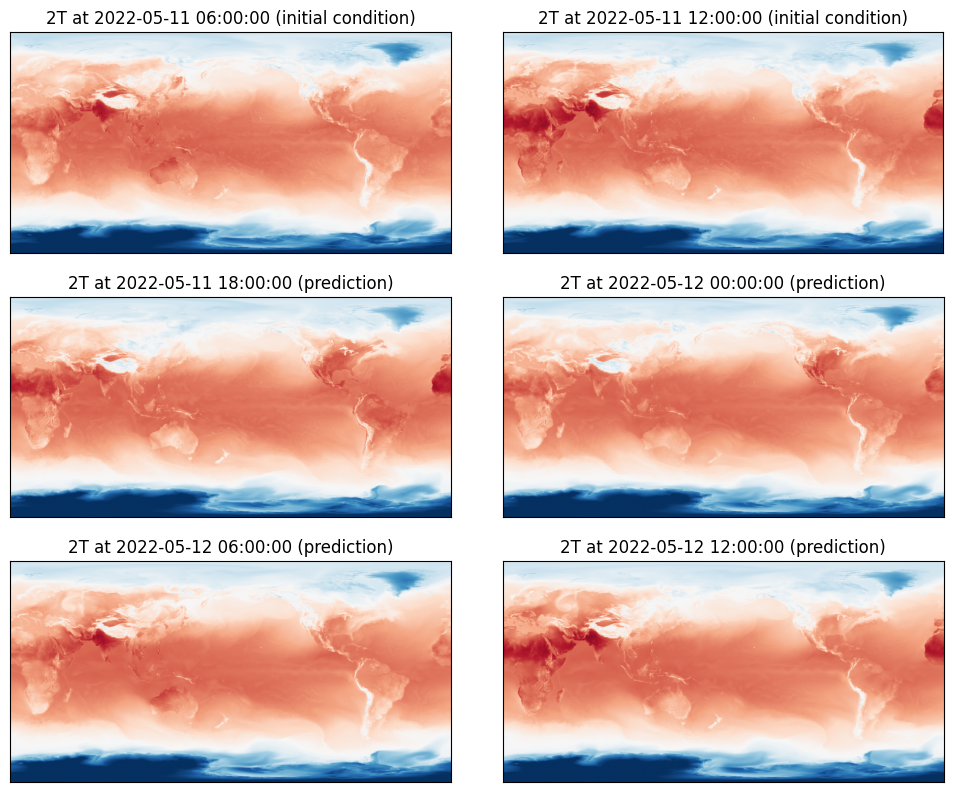

In [4]:
from datetime import timedelta

import matplotlib.pyplot as plt


def plot(ax, data, time, ic=True):
    ax.imshow(data.numpy() - 273.15, vmin=-50, vmax=50, cmap="RdBu_r")
    ax.set_title(f"2T at {time} " + ("(initial condition)" if ic else "(prediction)"))
    ax.set_xticks([])
    ax.set_yticks([])


fig, axs = plt.subplots(3, 2, figsize=(10, 8))
ic = initial_condition
plot(axs[0, 0], ic.surf_vars["2t"][0, 0], ic.metadata.time[0] - timedelta(hours=6))
plot(axs[0, 1], ic.surf_vars["2t"][0, 1], ic.metadata.time[0])
for i in range(2, 6):
    pred = predictions[i - 2]
    plot(axs[i // 2, i % 2], pred.surf_vars["2t"][0, 0], pred.metadata.time[0], ic=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

Aurora, however, predicts much more than just temperature: the model predicts the entire state of the atmosphere! Here is an interactive plot of the predictions for wind speed, temperature, and the mean pressure at sea level in the first step of the prediction:

In [5]:
from aurora.foundry.demo.interactive import interactive_plot

interactive_plot(predictions[0], width="1000px", height="500px")

Prediction for 2022-05-11 18:00


Map(center=[20, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…